In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mf.manfit_ours import manfit_ours
import math

from time import time

In [2]:
NumTrials = 1

D = 3
dim = 2
tau = 1
sigma = 0.1

In [3]:
def torusUnif(n, R, r):
    # generate n samples uniformly from a torus
    # R : the radius from the center of the hole to the center of the torus tube
    # r : the radius of the torus tube. 
    #
    # There is an R package with the same name
    # Algorithm 1 of Diaconis P, Holmes S, and Shahshahani M (2013). "Sampling from a manifold." 
    # Advances in Modern Statistical Theory and Applications: A Festschrift in honor of Morris L. Eaton. 
    # Institute of Mathematical Statistics, 102-125.
    
    count = 0
    theta = -np.ones((1, n))
    
    while count < n:
        xvec = np.random.rand(1)*2*math.pi
        yvec = np.random.rand(1)/math.pi
        fx = (1 + r/R*math.cos(xvec))/(2*math.pi)
        if yvec < fx:
            theta[:, count] = xvec
            count = count + 1
    
    phi = np.random.rand(1, n)*2*math.pi
    x = (R + r*np.cos(theta))*np.cos(phi)
    y = (R + r*np.cos(theta))*np.sin(phi)
    z = r*np.sin(theta)

    X = np.vstack((x, y, z))
    
    return X

In [4]:
def pdtorus(R, r, X):
    
    # return the projection p of x onto the torus:
    #    {(a,b,c) | (R-sqrt(a^2+b^2))^2+c^2 = r^2}
    # d = ||p-x||_2
    #
    # xiayq @ 8/14/2019
    #
    # xiayq@zju.edu.cn
    # refered to Yao, Z and Xia, Y. (2019). Manifold Fitting under Unbounded Noise, arXiv:1909.10228
    
    temp1 = np.sqrt(X[0, :]**2 + X[1, :]**2)
    temp2 = R/temp1
    temp3 = (R - temp1)**2 + X[2, :]**2
    w1 = r/np.sqrt(temp3)
    w0 = temp2 + (1 - temp2)*w1
    
    P = X*np.vstack((w0, w0, w1))
    
    d = np.sqrt(sum((X - P)**2))
    
    return [P, d]


In [5]:
num_samples = 1000
num_ini = 1000
a = 2/3; b = 1/3; 

samples = torusUnif(num_samples, a, b)
samples = samples + sigma*np.random.randn(D, num_samples)

data_ini = torusUnif(2*num_ini, a, b)
data_ini = data_ini + 2*sigma / np.sqrt(D)*(2*np.random.rand(D, 2 * num_ini) - 1)
[proj_data_ini,d] = pdtorus(a, b,data_ini)

norm_n2 = np.sum((data_ini - proj_data_ini) ** 2, axis=0)
indices = np.argsort(norm_n2)[::-1]
data_ini = data_ini[:, indices[:num_ini]]


/var/folders/fw/cb8tt6215jxcbsw44w1s71n00000gn/T/ipykernel_35529/1544376806.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fx = (1 + r/R*math.cos(xvec))/(2*math.pi)


In [6]:
tic = time()
Mout = manfit_ours(samples.T, sigma, data_ini.T)
Mout = Mout.T
toc = time() - tic

In [7]:

proj_Mout, dist_fit = pdtorus(a, b, Mout)

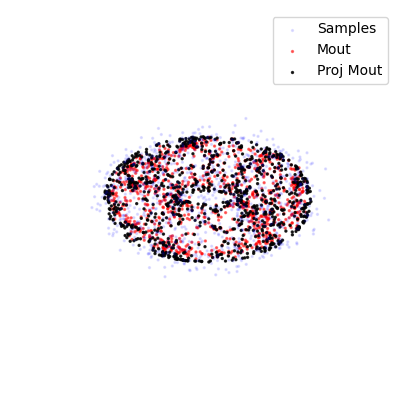

In [8]:
fig_width = 5
fig_height = 5

fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(samples[0, :], samples[1, :], samples[2, :], c='b', alpha=0.1, s=2, label='Samples')
ax.scatter(Mout[0, :], Mout[1, :], Mout[2, :], c='r', alpha=0.5, s=2, label='Mout')
ax.scatter(proj_Mout[0, :], proj_Mout[1, :], proj_Mout[2, :], c='k', alpha=0.8, s=2, label='Proj Mout')

ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_zlim([-1.2, 1.2])

ax.axis('off')
plt.legend()
plt.show()